In [41]:
pip install finterstellar

In [42]:
import pandas as pd
import finterstellar as fs

In [43]:
cd = 'MSFT'

In [44]:
df = fs.get_price(cd, start_date='2020-01-01')
df

,MSFT
2020-01-02,155.09
2020-01-03,153.16
2020-01-06,153.56
2020-01-07,152.16
2020-01-08,154.58
...,...
2023-10-02,321.80
2023-10-03,313.39
2023-10-04,318.96
2023-10-05,319.36


In [45]:
import plotly.express as px
px.line(df)

볼린저 밴드 계산

In [47]:
n = 20     # 평균주가계산 기준일수
sigma = 2     # 편차구간 지정 (시그마의 배수로)

In [49]:
def bollinger(n, sigma):
    df['center'] = df[cd].rolling(n).mean()
    # 데이터프레임[데이터].rolling(기준일자).mean() - 이동평균 계산
    df['ub'] = df['center'] + sigma * df[cd].rolling(n).std()
    # 데이터프레임[데이터].rolling(기준일자).std() - 이동표준편차 계산
    df['lb'] = df['center'] - sigma * df[cd].rolling(n).std()
    return df

In [50]:
bollinger(20, 2)

,MSFT,center,ub,lb
2020-01-02,155.09,NaN,NaN,NaN
2020-01-03,153.16,NaN,NaN,NaN
2020-01-06,153.56,NaN,NaN,NaN
2020-01-07,152.16,NaN,NaN,NaN
2020-01-08,154.58,NaN,NaN,NaN
...,...,...,...,...
2023-10-02,321.80,325.70,343.60,307.80
2023-10-03,313.39,324.69,343.00,306.38
2023-10-04,318.96,324.00,342.05,305.94
2023-10-05,319.36,323.47,341.41,305.53


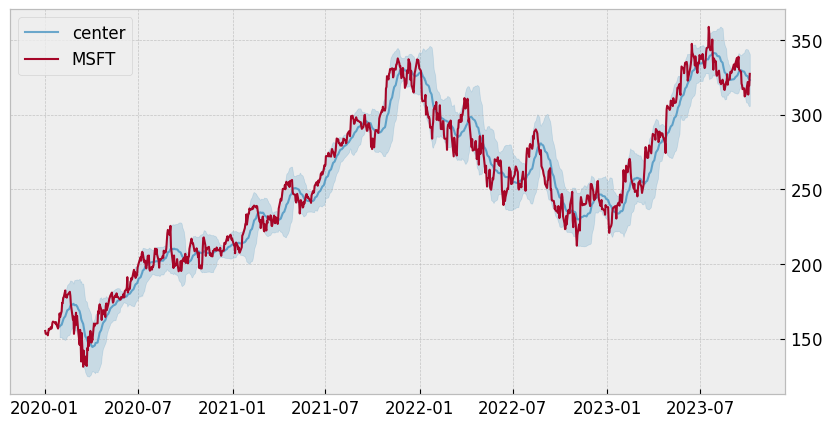

In [51]:
fs.draw_band_chart(df)

In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [53]:
def band_chart():
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=df.index, y=df['center'], name='MA', line={'color':'rgba(255,200,200,.5)'}),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['lb'], name='lb', line={'color':'rgba(255,200,200,.5)'}),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['ub'], name='ub', fill='tonexty', line={'color':'rgba(255,200,200,.5)'}, fillcolor='rgba(255,200,200,.3)'),
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df[cd], name='Price', line={'color':'crimson'}),
        secondary_y=True,
    )

    # Set y-axes titles
    fig.update_yaxes(secondary_y=True)

    fig.show()

In [54]:
band_chart()

트레이드 북 생성

In [55]:
def create_book():
    book = pd.DataFrame()    # 빈 트레이딩북(데이터프레임) 생성
    book[cd] = df[cd]    # sample에서 시세 복사
    book['t '+cd] = ''     # 매매전략 입력을 위한 trade 컬럼 생성
    book['p '+cd] = ''     # 포지션 입력을 위한 p 종목코드 컬럼 생성
    return book

In [56]:
book = create_book()
book

,MSFT,t MSFT,p MSFT
2020-01-02,155.09,,
2020-01-03,153.16,,
2020-01-06,153.56,,
2020-01-07,152.16,,
2020-01-08,154.58,,
...,...,...,...
2023-10-02,321.80,,
2023-10-03,313.39,,
2023-10-04,318.96,,
2023-10-05,319.36,,


트레이딩 전략 수립

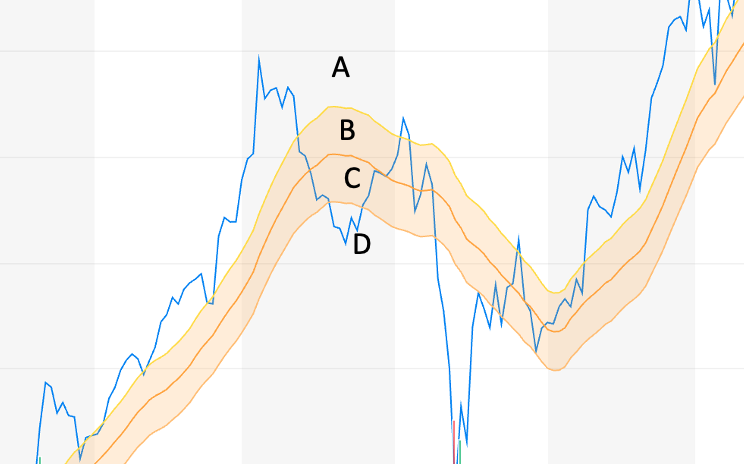

In [ ]:
# 백테스팅 매매전략 구현
'''
    df.loc[i, cd] : i일의 가격
    df.loc[i, center] : i일의 평균가격 (center)
    df.loc[i, ub] : i일의 상단가격 (upper bound)
    df.loc[i, lb] : i일의 하단가격 (lower bound)
'''
for i in df.index:    # sample에서 날짜를 하나씩 순환하며
    price = df.loc[i, cd]
    center = df.loc[i, 'center']
    lb = df.loc[i, 'lb']
    ub = df.loc[i, 'ub']
    # A
    if ub < price:
        # A 구역에서 매매 전략
        pass
    # B
    elif center < price and price <= ub:
        # B 구역에서 매매 전략
        pass
    # C
    elif lb <= price and price <= center:
        # C 구역에서 매매 전략
        pass
    # D
    elif price <= lb:
        # D 구역에서 매매 전략
        pass


##평균회귀 전략
D 구역 진입 시 매수, B 구역 진입 시 매도

In [57]:
# 백테스팅 매매전략 구현
for i in df.index:    # sample에서 날짜를 하나씩 순환하며
    price = df.loc[i, cd]
    center = df.loc[i, 'center']
    lb = df.loc[i, 'lb']
    ub = df.loc[i, 'ub']
    # A
    if ub < price:
        book.loc[i, 't '+cd] = ''    # trade : sell
    # B
    elif center < price and price <= ub:
        book.loc[i, 't '+cd] = ''    # trade : sell
    # C
    elif lb <= price and price <= center:
        if book.shift(1).loc[i, 't '+cd] == 'buy':
            book.loc[i, 't '+cd] = 'buy'     # trade : buy (buy 유지)
        else:
            book.loc[i, 't '+cd] = ''     # trade : neutral (zero 유지)
    # D
    elif price <= lb:
        book.loc[i, 't '+cd] = 'buy'    # buy

In [58]:
book['2020-03-20':'2020-03-31']

,MSFT,t MSFT,p MSFT
2020-03-20,132.99,buy,
2020-03-23,131.66,buy,
2020-03-24,143.63,buy,
2020-03-25,142.25,buy,
2020-03-26,151.15,,
2020-03-27,144.94,,
2020-03-30,155.14,,
2020-03-31,152.70,,


트레이딩 전략에 따른 포지션

In [59]:
def cal_position():
    status = ''
    for i in book.index:
        if book.loc[i, 't '+cd] == 'buy':    # 매수 상태에서는
            if book.shift(1).loc[i, 't '+cd] == 'buy':    # 이미 매수 상태였다면
                status = 'll'     # long -> long 유지
            elif book.shift(1).loc[i, 't '+cd] == '':     # zero 상태였다면
                status = 'zl'     # zero -> long
            else:
                status = 'zl'     # zero -> long
        elif book.loc[i, 't '+cd] == '':
            if book.shift(1).loc[i, 't '+cd] == 'buy':
                status = 'lz'     # long -> zero
            elif book.shift(1).loc[i, 't '+cd] == '':
                status = 'zz'     # zero -> zero
            else:
                status = 'zz'     # zero -> zero
        else:
            status = 'zz'     # zero -> zero
        book.loc[i, 'p '+cd] = status

In [60]:
cal_position()

In [61]:
book['2020-03-20':'2020-03-31']

,MSFT,t MSFT,p MSFT
2020-03-20,132.99,buy,ll
2020-03-23,131.66,buy,ll
2020-03-24,143.63,buy,ll
2020-03-25,142.25,buy,ll
2020-03-26,151.15,,lz
2020-03-27,144.94,,zz
2020-03-30,155.14,,zz
2020-03-31,152.70,,zz


수익률 계산

In [62]:
def cal_return():
    # 초기 수익률 1로 세팅 (누적곱)
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        pos = book.loc[i, 'p '+cd]
        if pos == 'zl' or pos == 'sl' :     # long 진입
            buy = book.loc[i, cd]    # 매수 가격 확정
            print(i.date(), 'long '+cd, buy)
        elif pos == 'lz' or pos == 'ls' :     # long 청산
            sell = book.loc[i, cd]    # 매도 가격 확정
            # 손익 계산
            rtn = sell / buy
            # 손익 = (매도가-매수가)/매수가 + 1 , 100원 투자해서 10원 벌면 손익은 1.10
            book.loc[i, 'return'] = rtn    # 트레이딩북에 손익 기록
            print(i.date(), 'long '+cd, buy, ' | unwind long '+cd, sell, ' | return:', round(rtn, 4))

        # 공매도가 허용되는 경우라면
        elif pos == 'zs' or pos == 'ls' :     # short 진입
            sell = book.loc[i, cd]    # 공매도 가격 확정
            print(i.date(), 'short '+cd, sell)
        elif pos == 'sz' or pos == 'sl' :     # short 청산
            buy = book.loc[i, cd]    # 숏커버 가격 확정
            # 손익 계산
            rtn = buy / sell
            book.loc[i, 'return'] = rtn
            print(i.date(), 'short '+cd, sell, ' | unwind short '+cd, buy, ' | return:', round(rtn, 4))

    if book.loc[i, 't '+cd] == '' and pos == '':     # zero position
        buy = 0.0
        sell = 0.0

    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn
        book.loc[i, 'acc return'] = acc_rtn

    print('Accunulated return :', round(acc_rtn, 4))
    return acc_rtn

In [63]:
acc_rtn = cal_return()

2020-02-27 long MSFT 153.15
2020-03-26 long MSFT 153.15  | unwind long MSFT 151.15  | return: 0.9869
2020-10-28 long MSFT 197.26
2020-11-04 long MSFT 197.26  | unwind long MSFT 210.61  | return: 1.0677
2021-02-25 long MSFT 223.97
2021-03-11 long MSFT 223.97  | unwind long MSFT 231.93  | return: 1.0355
2021-05-04 long MSFT 242.36
2021-05-24 long MSFT 242.36  | unwind long MSFT 245.85  | return: 1.0144
2021-09-20 long MSFT 289.06
2021-10-07 long MSFT 289.06  | unwind long MSFT 289.6  | return: 1.0019
2021-12-03 long MSFT 317.84
2021-12-07 long MSFT 317.84  | unwind long MSFT 329.56  | return: 1.0369
2022-01-05 long MSFT 311.32
2022-01-31 long MSFT 311.32  | unwind long MSFT 306.01  | return: 0.9829
2022-02-23 long MSFT 276.36
2022-03-02 long MSFT 276.36  | unwind long MSFT 296.0  | return: 1.0711
2022-03-07 long MSFT 275.02
2022-03-16 long MSFT 275.02  | unwind long MSFT 290.28  | return: 1.0555
2022-04-11 long MSFT 281.28
2022-05-04 long MSFT 281.28  | unwind long MSFT 285.93  | return:

In [64]:
def cal_excess_rtn():
    # 벤치마크 수익률
    bm_rtn = round ( book[cd].iloc[-1] / book[cd].iloc[0], 4)
    print('BM return:', round(bm_rtn, 4) )
    exs_rtn = (acc_rtn - bm_rtn)
    print('Excess return:', round(exs_rtn, 4) )

In [65]:
cal_excess_rtn()

BM return: 2.1101
Excess return: -0.2103


Charting

Draw Position

In [66]:
book

,MSFT,t MSFT,p MSFT,return,acc return
2020-01-02,155.09,,zz,1.00,1.00
2020-01-03,153.16,,zz,1.00,1.00
2020-01-06,153.56,,zz,1.00,1.00
2020-01-07,152.16,,zz,1.00,1.00
2020-01-08,154.58,,zz,1.00,1.00
...,...,...,...,...,...
2023-10-02,321.80,buy,ll,1.00,1.84
2023-10-03,313.39,buy,ll,1.00,1.84
2023-10-04,318.96,buy,ll,1.00,1.84
2023-10-05,319.36,buy,ll,1.00,1.84


In [67]:
book[(book['p '+cd]=='ll') | (book['p '+cd]=='zl') | (book['p '+cd]=='sl')]

,MSFT,t MSFT,p MSFT,return,acc return
2020-02-27,153.15,buy,zl,1.00,1.00
2020-02-28,156.86,buy,ll,1.00,1.00
2020-03-02,167.30,buy,ll,1.00,1.00
2020-03-03,159.28,buy,ll,1.00,1.00
2020-03-04,165.13,buy,ll,1.00,1.00
...,...,...,...,...,...
2023-09-29,315.75,buy,ll,1.00,1.84
2023-10-02,321.80,buy,ll,1.00,1.84
2023-10-03,313.39,buy,ll,1.00,1.84
2023-10-04,318.96,buy,ll,1.00,1.84


In [ ]:
book[book['p '+cd].str[1]=='l']

Draw Return

In [68]:
def trade_result_chart():
    df['position'] = 0    # 포지션 기록용 컬럼 추가, 디폴트로 0 세팅
    df.loc[book['p '+cd].str[1]=='l', 'position'] = 1    # long 포지션은 1 기록

    df['acc_rtn'] = book['acc return']

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=df.index, y=df['center'], name='MA', line={'color':'rgba(255,200,200,.5)'}),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['lb'], name='lb', line={'color':'rgba(255,200,200,.5)'}),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['ub'], name='ub', fill='tonexty', line={'color':'rgba(255,200,200,.5)'}, fillcolor='rgba(255,200,200,.3)'),
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df[cd], name='Price', line={'color':'crimson'}),
        secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df['position'], name='Position', fill='tozeroy', line={'color':'rgba(30,144,255,.5)'}, fillcolor='rgba(30,144,255,.3)', yaxis='y3'),
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df['acc_rtn'], name='Return', line={'color':'white'}),
    )

    # Set y-axes titles
    fig.update_yaxes(secondary_y=True)

    fig.update_layout(
        template='plotly_dark',
        margin=dict(l=10, r=10, t=10, b=10),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        yaxis2=dict(title='BM return', anchor='x', overlaying='y', side='right', tickmode='sync',),
        yaxis3=dict(title='Position', anchor='free', overlaying='y', side='left', position=.1, visible=False),
    )
    fig.show()

In [69]:
trade_result_chart()

#모멘텀 전략

A 구역 진입 시 매수, A 구역 벗어나면 매도

In [70]:
df = df[[cd, 'center', 'ub', 'lb']]
df.tail()

,MSFT,center,ub,lb
2023-10-02,321.80,325.70,343.60,307.80
2023-10-03,313.39,324.69,343.00,306.38
2023-10-04,318.96,324.00,342.05,305.94
2023-10-05,319.36,323.47,341.41,305.53
2023-10-06,327.26,323.12,340.43,305.80


In [71]:
create_book()

,MSFT,t MSFT,p MSFT
2020-01-02,155.09,,
2020-01-03,153.16,,
2020-01-06,153.56,,
2020-01-07,152.16,,
2020-01-08,154.58,,
...,...,...,...
2023-10-02,321.80,,
2023-10-03,313.39,,
2023-10-04,318.96,,
2023-10-05,319.36,,


In [72]:
# 백테스팅 매매전략 구현
for i in df.index:    # sample에서 날짜를 하나씩 순환하며
    price = df.loc[i, cd]
    center = df.loc[i, 'center']
    lb = df.loc[i, 'lb']
    ub = df.loc[i, 'ub']
    # A
    if ub < price:
        book.loc[i, 't '+cd] = 'buy'    # trade : buy
    # B
    elif center < price and price <= ub:
        book.loc[i, 't '+cd] = ''    # trade : sell
    # C
    elif lb <= price and price <= center:
        book.loc[i, 't '+cd] = ''    # trade : sell
    # D
    elif price <= lb:
        book.loc[i, 't '+cd] = ''    # trade : sell

In [73]:
book[book['t '+cd]=='buy'].tail()

,MSFT,t MSFT,p MSFT,return,acc return
2023-06-15,347.36,buy,zz,1.00,1.84
2023-07-18,358.73,buy,zz,1.00,1.84
2023-07-19,354.33,buy,zz,1.00,1.84
2023-09-05,333.55,buy,zz,1.00,1.84
2023-09-11,337.94,buy,zz,1.00,1.84


In [74]:
cal_position()

In [75]:
acc_rtn = cal_return()

2020-01-30 long MSFT 166.84
2020-01-31 long MSFT 166.84  | unwind long MSFT 164.37  | return: 0.9852
2020-02-03 long MSFT 168.38
2020-02-07 long MSFT 168.38  | unwind long MSFT 177.56  | return: 1.0545
2020-02-10 long MSFT 182.21
2020-02-11 long MSFT 182.21  | unwind long MSFT 178.09  | return: 0.9774
2020-06-08 long MSFT 182.88
2020-06-11 long MSFT 182.88  | unwind long MSFT 180.85  | return: 0.9889
2020-06-22 long MSFT 194.74
2020-06-23 long MSFT 194.74  | unwind long MSFT 196.04  | return: 1.0067
2020-07-06 long MSFT 204.57
2020-07-07 long MSFT 204.57  | unwind long MSFT 202.2  | return: 0.9884
2020-08-26 long MSFT 215.24
2020-08-31 long MSFT 215.24  | unwind long MSFT 219.5  | return: 1.0198
2020-10-09 long MSFT 210.04
2020-10-14 long MSFT 210.04  | unwind long MSFT 214.96  | return: 1.0234
2020-12-16 long MSFT 213.98
2020-12-18 long MSFT 213.98  | unwind long MSFT 213.31  | return: 0.9969
2020-12-21 long MSFT 217.21
2020-12-23 long MSFT 217.21  | unwind long MSFT 215.68  | return:

In [76]:
cal_excess_rtn()

BM return: 2.1101
Excess return: -1.0902


In [77]:
trade_result_chart()

###CAGR: -19.90%
###Accumulated return: -18.70%
###Average return: nan%
###Benchmark return : -25.88%
###Number of trades: 1
###Number of win: 0
###Hit ratio: 0.00%
###Investment period: 0.9yrs
###Sharpe ratio: -0.99
###MDD: -32.14%
###Benchmark MDD: -35.86%


In [ ]:
acc_rtn

In [ ]:
print(book.index[0], book.index[-1])

In [ ]:
(book.index[-1] - book.index[0])